### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import openpyxl

from matplotlib import pyplot as plt
from subprocess import call
from IPython.display import Image


from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import export_graphviz
from sklearn import tree

from tqdm import tqdm

sns.set()
%matplotlib inline

### 2. Loading data

In [3]:
# Load data, check shape, and look at (some of) the first 5 rows
recs = pd.read_csv('dataset.csv')
print(recs.shape)
recs.head()

(12083, 940)


C:\Users\usman\AppData\Local\Temp\ipykernel_22068\1662040144.py:2: DtypeWarning: Columns (717,718) have mixed types. Specify dtype option on import or set low_memory=False.
  recs = pd.read_csv('dataset.csv')


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEKER,IECC_Climate_Pub,HDD50,CDD80,GND_HDD65,WSF,OA_LAT,GWT,DesignDBT99,DesignDBT1
0,1,2,4,12,2,2471.68,4742,1080,4953,1271,...,-2,4A,2117,56,4250,0.48,6,56,9,96
1,2,4,10,26,2,8599.17,2662,199,2688,143,...,-2,3C,62,26,2393,0.61,0,64,38,73
2,3,1,1,1,5,8969.92,6233,505,5741,829,...,-2,5A,2346,49,5654,0.48,3,52,12,88
3,4,2,3,7,2,18003.64,6034,672,5781,868,...,-2,5A,2746,0,4941,0.55,4,55,7,87
4,5,1,1,1,3,5999.61,5388,702,5313,797,...,-2,5A,2251,0,5426,0.61,4,50,13,90


### 3. Data Engineering/Preparation

##### Dropping Columns

In the following code sections, different columns were dropped for different reasons:
* **Non-predictive Columns**: These columns do not contain information for making predictions. For example, the region (REGIONNC) and division (DIVISION) fields can be inferred from the reportable domain. So to reduce the number of predictors as well as avoiding the introduction of any correlation in the model predictors, they were dropped.
* **Total Columns**: These columns tabulate total uses of fuel(s), dollar amount(s) for the fuel uses and provides estimates of energy use in KWH and BTU. It was assumed we would not know the energy use for the different types beforehand, and most likely only the dollar amounts would be known from billing/documents
* **Imputation Columns**: These columns identify the records for the associated column populated by inferring values for similar cases in the event the data was missing or the participant refused to answer. While these columns would be useful for assessing the data quality, it was assumed that the values were correctly imputed, so these columns were dropped as they are not useful to the model.



In [4]:
# Drop non-predictive columns
non_predictive_columns = ['DOEID', 'NWEIGHT', 'REGIONC', 'DIVISION']
recs_data = recs.drop(non_predictive_columns, axis = 1)

In [5]:
# Dropping Total energy use columns
# Indicate dollar columns to keep, store it in a separate dataframe, drop columns (including the dollar columns) in a range
# then add the dataframe with the dollar columns back to the raw data
dollar_columns_to_keep = ['DOLLAREL', 'DOLLARNG', 'DOLLARLP', 'DOLLARFO', 'DOLLARKER', 'TOTALDOL']
df_to_keep = recs_data[dollar_columns_to_keep]
recs_data = recs_data.drop(recs_data.loc[:, 'KWHSPH':'SCALEKER'].columns, axis = 1)
recs_data[dollar_columns_to_keep] = df_to_keep

In [6]:
# Drop columns with imputation indicators (columns starting with Z)
z_columns = [col for col in recs_data.columns if col[0].upper() == 'Z']
recs_data = recs_data.drop(z_columns, axis = 1)
# Print result of operation and new shape of dataframe
print("Number of imputation indicator columns dropped: {}".format(len(z_columns)))
recs_data.shape

Number of imputation indicator columns dropped: 359


(12083, 492)

##### Checking for missing and/or duplicate rows

In [7]:
# Check for missing and duplicated values
n_missing = recs_data.isnull().sum().sum()
n_duplicated = recs_data.duplicated().sum()

print('Number of duplicated rows: {}'.format(n_duplicated))
print('Number of rows missing values: {}'.format(recs_data.isnull().sum().sum()))

# Check for non-numeric columns
categorical_columns = recs_data.select_dtypes(exclude = 'number').columns

for col in categorical_columns:
    print(f'{col} values include : {recs_data[col].unique()}\n')

Number of duplicated rows: 0
Number of rows missing values: 0
METROMICRO values include : ['METRO' 'MICRO' 'NONE']

UR values include : ['U' 'R']

NOCRCASH values include : [-2 1 6 15 4 '-2' '1' '20' '.' '12' '4' '10' '3' '24' '55' '6' 8 28 5 55 3
 16 2 20 10 24 40 12 25]

NKRGALNC values include : [-2 1 5 10 '-2' '10' '15' '1' '8' '.' '5' '3' '2' '77' 30 3 15 8 55 2 20]

IECC_Climate_Pub values include : ['4A' '3C' '5A' '6A-6B' '1A-2A' '3B-4B' '3A' '5B-5C' '7A-7B-7AK-8AK' '2B'
 '4C']



In [8]:
'''
The NOCRCASH and NKRGALNC column contain periods in the data.
Rows with these values will be dropped and the columns will be cast to int64 datatypes
'''
# Create list to store number of rows dropped
total_rows_dropped = []
cols_to_clean = ['NOCRCASH', 'NKRGALNC']

# For each of the columns in cols_to_clean, find the rows with a period,
# add it to the list of total dropped rows, drop it from the recs_data
# then recast the column to integer
for col in cols_to_clean:
    rows_to_drop = recs_data[(recs_data[col] == '.')].index
    total_rows_dropped += list(rows_to_drop)
    recs_data = recs_data.drop(index = rows_to_drop)
    recs_data[col] = recs_data[col].astype('int64')

# Check Result for number of rows dropped (if more than 10, indicate only the count)
if (len(total_rows_dropped) > 10):
    print(f'Dropped {len(total_rows_dropped)} rows\n')
else:
    print(f'{len(total_rows_dropped)} Rows dropped with indices: {total_rows_dropped}\n')

# Check Resulting dataframe for non-numeric types
categorical_columns = recs_data.select_dtypes(exclude = 'number').columns
for col in categorical_columns:
    print(f'{col} values include : {recs_data[col].unique()}\n')

2 Rows dropped with indices: [1387, 2092]

METROMICRO values include : ['METRO' 'MICRO' 'NONE']

UR values include : ['U' 'R']

IECC_Climate_Pub values include : ['4A' '3C' '5A' '6A-6B' '1A-2A' '3B-4B' '3A' '5B-5C' '7A-7B-7AK-8AK' '2B'
 '4C']



##### Encoding string/object columns
One hot encoding was used because the values are not indicative of magnitude that would allow us to compare a value to another. Therefore a column identifying which range the value falls into was used.

In [9]:
# Convert remaining columns (METROMICRO, UR and IECC_Climate_Pub)
# to categorical using one-hot encoding, then drop original column from raw data
recs_data = pd.concat([recs_data, pd.get_dummies(recs_data['METROMICRO'], prefix='METROMICRO')], axis=1)
recs_data = recs_data.drop(labels = ['METROMICRO'], axis = 1)

recs_data = pd.concat([recs_data, pd.get_dummies(recs_data['UR'], prefix='UR')], axis=1)
recs_data = recs_data.drop(labels = ['UR'], axis = 1)

recs_data = pd.concat([recs_data, pd.get_dummies(recs_data['IECC_Climate_Pub'], prefix='IECC_Climate_Pub')], axis=1)
recs_data = recs_data.drop(labels = ['IECC_Climate_Pub'], axis = 1)

In [10]:
# Drop observations with standardized coding (containing -8 or -9 as they indicate "Refuse" and "Don't Know" responses respectively)
for col in recs_data.columns:
    rows_to_drop = recs_data[(recs_data[col] == -8) | (recs_data[col] == -9)].index
    try:
        recs_data2 = recs_data2.drop(index = rows_to_drop)
    except:
        recs_data2 = recs_data.drop(index = rows_to_drop)   
# Shape of cleaned dataframe:
print(f'Shape of cleaned dataframe: {recs_data2.shape}')

Shape of cleaned dataframe: (11941, 505)


### 4. Exploratory Data Analysis

In [11]:
# Get summary statistics on output
recs_data2['KWH'].describe()

count     11941.00000
mean      11302.79047
std        7650.79766
min          17.00000
25%        5849.00000
50%        9640.00000
75%       14771.00000
max      150254.00000
Name: KWH, dtype: float64

[Text(0.5, 1.0, 'Histogram of Output (KHW)')]

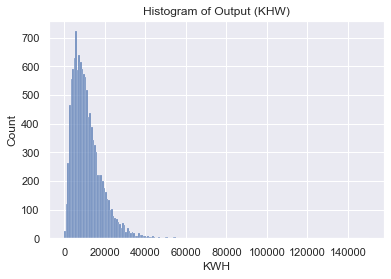

In [12]:
# Plot a histogram of the output
sns.histplot(data = recs_data2, x = recs_data['KWH']).set(title='Histogram of Output (KHW)')

The distribution of the output looks like a positively skewed normal distribution, or a gamma distribution. What this indicates is that using a linear regression model would be very difficult, and variance stabilizing transforms or transformations of the output variable would be extensively used. This is to account for the fact that the output variable distribution strays from a  normal distribution; a key assumption made when using linear regression. Insteadof linear regression, a gamma regressor or ensemble should be investigated as possible candidates for a model. 

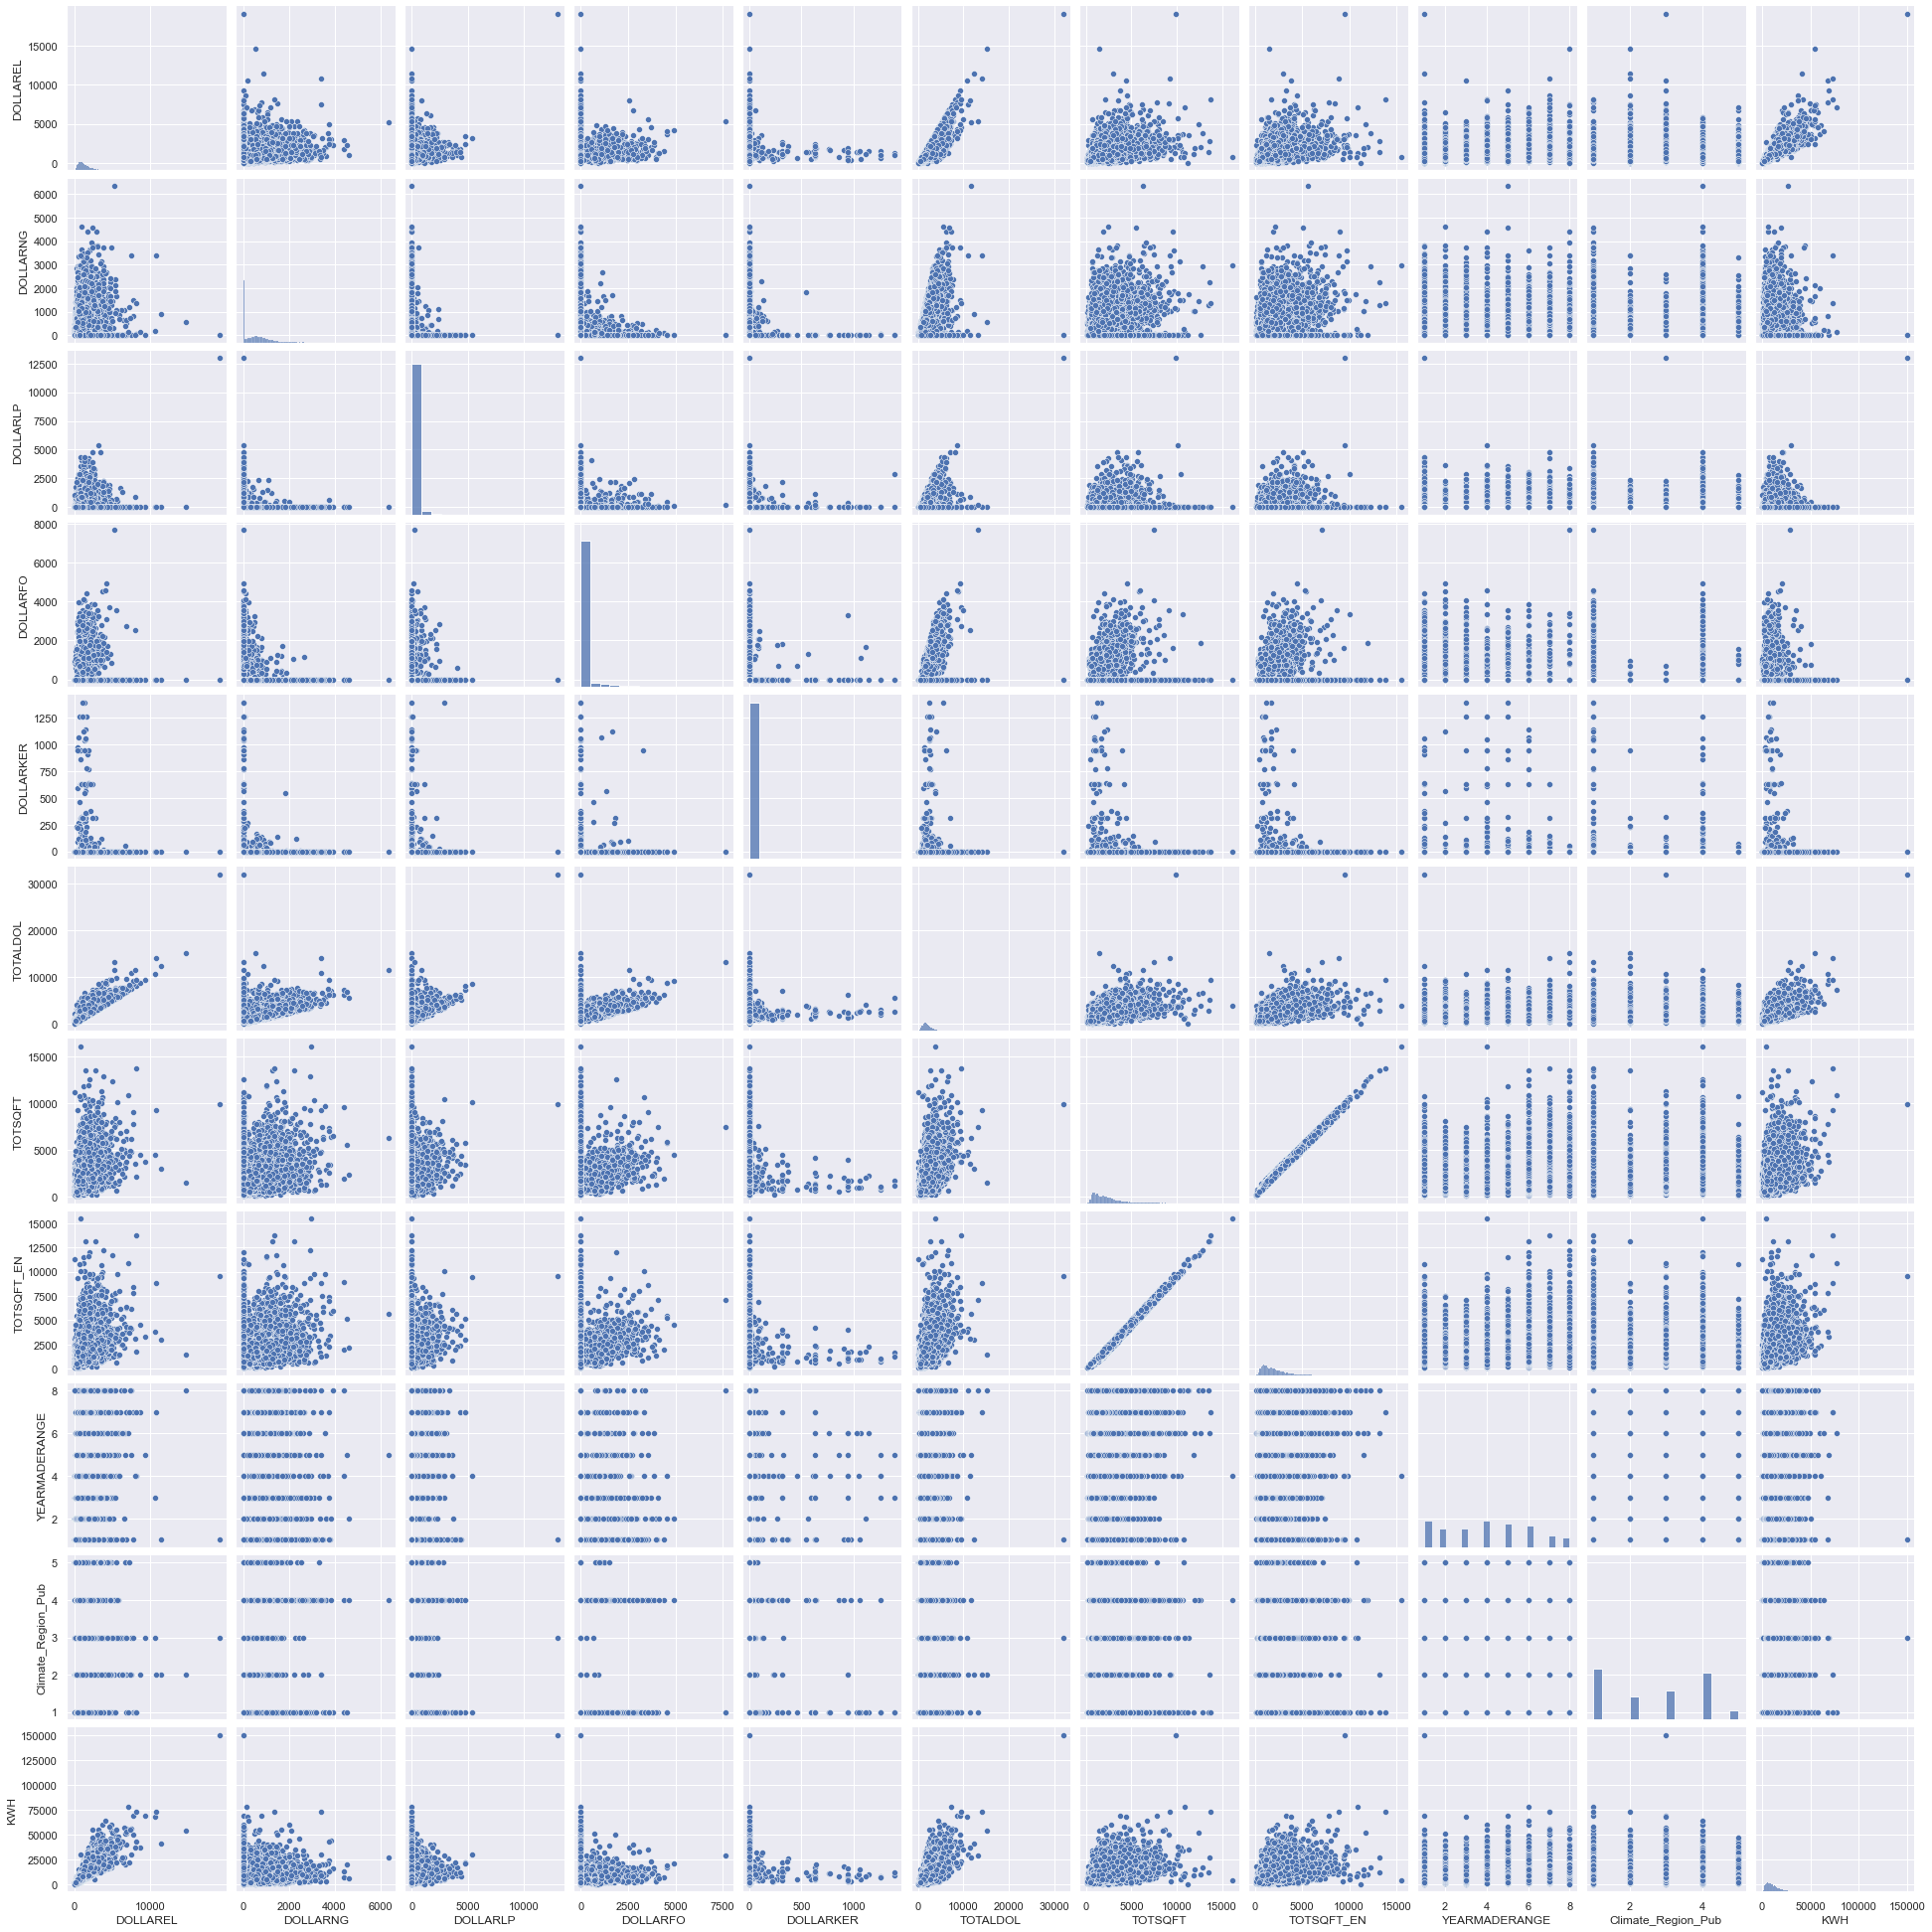

In [13]:
# Since it is a regression model (making predictions on a continuous scale), plot continuous variables in data,
#  as well as some discrete variables highlighted as critical to making estimates by additional resources from RECS page
recs_data_plot = recs_data2[dollar_columns_to_keep+ ['TOTSQFT','TOTSQFT_EN','YEARMADERANGE','Climate_Region_Pub','KWH']]
sns.pairplot(recs_data_plot)

From creating pairplots, we can see some relationships that exists between some predictive columns and the output. For example, a roughly linear relationship exists between the DOLLAREL and the output KWH. This relationship makes sense due to the electricity usage being related to how much a household would be billed based on pricing of electricity and usage by individual households across the country.

### 5. Model Building & Intiial Testing- Random Forest Regressor

In [14]:
# Split data into training and test sets
X = recs_data2.drop(['KWH'], axis = 1)
Y = recs_data2['KWH']
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [15]:
# Parameters
n_estimators = 100  # Number of trees can be tuned to find at which point is there no benefit to accuracy of model by adding more trees

In [16]:
# Create a Model
model = RandomForestRegressor(n_estimators = n_estimators, criterion = 'squared_error', min_impurity_decrease = 0.001, oob_score = True)

### Initial Training and Results

In [17]:
# Fit a model for initial results and get training R-squared of the model
model.fit(X_train, Y_train)
print(f'Training R_squared is: {model.score(X_train, Y_train)}')

Training R_squared is: 0.9832169003242686


### 6. Tuning Parameters

In [18]:
'''
WARNING: THIS CELL TAKES 10+ MINUTES TO RUN
'''
# This section iteratively increases the number of trees to determine the optimal number of trees,
# defined as the number of trees where there is not much reduction in MSE& MAE errors, oob r-squared and training r-squared

# Create lists to store observations
MAE = []
MSE = []
oob_r_squared = []
training_r_squared = []

# Fit data from 20 to 401 trees, and create initial model to be used for training (warm_start set to True)
starting_estimators = 20
ending_estimators = 401
model = RandomForestRegressor(n_estimators = starting_estimators, criterion = 'squared_error',\
    warm_start = True, min_impurity_decrease = 0.001, oob_score = True)

# Increase the number of trees in the random forest each iteration
for n_estimators in tqdm(range(starting_estimators,ending_estimators,1),'Number of Estimators'):
    # Create a model
    model.set_params(n_estimators = n_estimators)
    # Fit the model with the increased number of estimators
    model.fit(X_train, Y_train)
    # Caluclate MAE, MSE, training R2 and OOB R^2 of fitted model
    mean_absolute_error = ( abs(model.predict(X_train) - Y_train ) ).mean()
    mean_squared_error = ( (model.predict(X_train) - Y_train ) ** 2 ).mean()
    training_r_2 = model.score(X_train, Y_train)
    oob_r_2 = model.oob_score_
    # append the values to the lists
    MAE.append(mean_absolute_error)
    MSE.append(mean_squared_error)
    training_r_squared.append(training_r_2)
    oob_r_squared.append(oob_r_2)

Number of Estimators:   0%|          | 0/381 [00:00<?, ?it/s]c:\Users\usman\anaconda3\envs\data_science_cloud\lib\site-packages\sklearn\ensemble\_forest.py:560: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
  warn(
Number of Estimators: 100%|██████████| 381/381 [26:05<00:00,  4.11s/it]


In [28]:
# Create a dataframe of lists for later use
model_validation = pd.DataFrame({'Estimators': range(starting_estimators,ending_estimators,1),\
    'r_squared': training_r_squared,'oob_r_squared': oob_r_squared,\
      'MAE': MAE, 'MSE': MSE  })
model_validation.head()

,Estimators,r_squared,oob_r_squared,MAE,MSE
0,20,0.979931,0.865978,591.692056,1.189380e+06
1,21,0.979930,0.867969,587.234741,1.189437e+06
2,22,0.979621,0.868723,585.966908,1.207798e+06
3,23,0.980123,0.869722,584.912538,1.178013e+06
4,24,0.980468,0.870217,582.785635,1.157549e+06


In [29]:
# Melt dataframe for plotting r-squared values
model_validation_plot = pd.melt(model_validation[['Estimators','r_squared', 'oob_r_squared']], id_vars=['Estimators'], value_vars=['r_squared', 'oob_r_squared'],var_name = 'Measure')
model_validation_plot.head()

,Estimators,Measure,value
0,20,r_squared,0.979931
1,21,r_squared,0.979930
2,22,r_squared,0.979621
3,23,r_squared,0.980123
4,24,r_squared,0.980468


[Text(0.5, 1.0, 'Number of estimators vs Training R-squared and Out of Bag R-squared')]

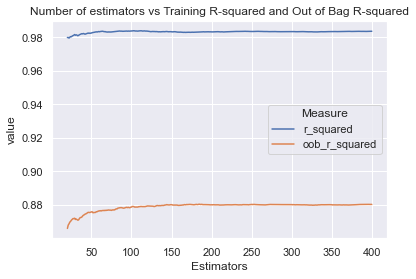

In [30]:
# Plot r-squared values
sns.lineplot(data=model_validation_plot, x='Estimators', y='value', hue='Measure').set(title='Number of estimators vs Training R-squared and Out of Bag R-squared')

Looking at the training $R^{2}$ and out-of-bag $R^{2}$, we see that the number of estimators that does not add much improvement to the model(s) is at around 200 estimators. The value of the at $R^{2}$ being at about 0.98 indicates that the model does an excellent job of explaining the data, while the lower oob $R^{2}$ says that we can expect a value of close to 0.88 as this is the value for records not used in training the estimator(s). Using a number of estimators greater than 200 means that we can achieve good performance, without having to use a large number of estimators, which reduces the size of the model.

[Text(0.5, 1.0, 'Number of estimators vs MSE')]

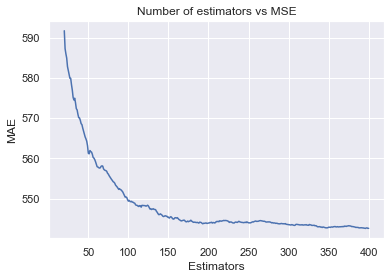

In [22]:
# Plot number of estimators vs Mean squared error values 
sns.lineplot(data=model_validation, x='Estimators', y='MAE').set(title='Number of estimators vs MAE')

The Training Mean Absolute Error (MAE) MAE of the model (looks to settle at about 300 estimators), which suggests that this number of estimators (or more) should be used.

Text(0.5, 0, 'Number of Estimators')

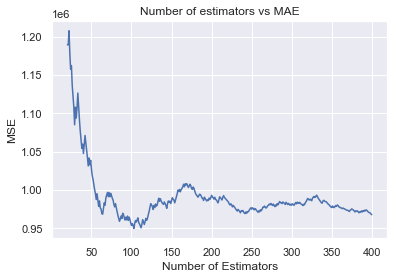

In [37]:
# Plot number of estimators vs Mean absolute error values 
sns.lineplot(data=model_validation, x='Estimators', y='MSE').set(title='Number of estimators vs MAE')
plt.xlabel("Number of Estimators")


Though the data appears to be very noisy, it appears that the MSE value settles at about 300 for the number of estimators. From looking at the validation metrics, 350 estimators was used, in order to gurantee convergence of the MAE and MSE metrics, as it was known that the $R^{2}$ metrics converged at more than 200 estimators.

### 7. Testing model

In [31]:
# Using value of 350 selected from tuning hyper parametes, train a final model and fit it to training data
model = RandomForestRegressor(n_estimators = 350, criterion = 'squared_error',\
     min_impurity_decrease = 0.001, oob_score = True)
model.fit(X_train, Y_train)

RandomForestRegressor(min_impurity_decrease=0.001, n_estimators=350,
                      oob_score=True)

In [35]:
print(f'Training r-squared: {model.score(X_train, Y_train)}')
print(f'Training oob score: {model.oob_score_}')

Training r-squared: 0.9841905420682316
Training oob score: 0.880843872645398


In [36]:
print(f'Testing r-squared: {model.score(X_test, Y_test)}')

Testing r-squared: 0.9013609702978804


### 8. Additional Data- Feature Importance

[Text(0.5, 1.0, 'Feature Name vs Importance')]

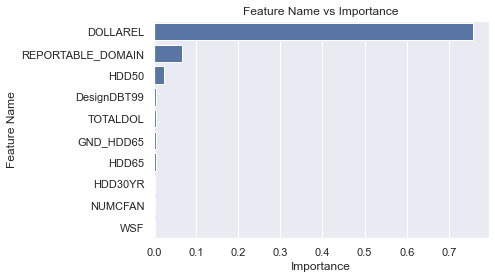

In [34]:
# Turn Feature importances into a datafame and then sort in descending order
importances = pd.DataFrame({'Importance': model.feature_importances_, 'Feature Name' : X_train.columns})

importances.sort_values(by = 'Importance', ascending = False, inplace = True)
importances.head(10)
# Plot the first 10 features
sns.barplot(x="Importance", y="Feature Name", data=importances.head(10), color = 'b').set(title='Feature Name vs Importance')

# Conclusion

### Assumptions:
<li> Data with imputation flags are assumed to be correctly evaluated and used in prediction, as recommended by EIA to avoid bias in reporting
<li> Removed records coded with -8 and -9, it was assumed the reduction in records ()
<li> Removed data quality flags columns as it was ssumed these do not add to the predictive power of the model
<li> Removed total usage of fuel, natural gas etc as it was assumed customers/ survey particiapants would not have this information when collecting data

<br>
<br>

### Analysis

#### Model:
The model chosen was a random forest regressor for two main reasons: the size of the model and the complexity of its validation. From plotting the KWH, the data looked like it followed a right skewed normal distribution or gamma distribution which would then call for a linear or gamma regresser respectively. However a linear model was not used because the large number of predictors containing categorical data meant that the resulting model equations would be very large after encoding the categorical predictors. Furthermore, the skew of the distribution and the large number of features meant in the case of a linear model, variance stabilizing transforms of the predictors as well as feature selection methods in the form of Lasso regression or step selection would have to be extensively used to reduce the number of predictors/account for the skew in the data, making the validation of the model significantly more complex. On the other hand, a decision tree/random forest would be able to understand the implicit meaning(s) of the categorical data, meaning a lower number of predictors would have to be engineered from not having to encode the categorical data. Also, the feature importances of variables can be easily extracted to determine which columns are the most useful in making predictions on the data, in order to convey information about which predictors are most useful in making predictions


#### Training/ Tuning Parameters:
When training the model, the following was investigated:
    1) The $R^{2}$: This would give an understanding of how well the model account for the variance in the observed data, and a high value for $R^{2}$ would mean the model was could be used for making predictions.
    2) The out-of-bag (OOB) score: This is the $R^{2}$ score associated with observations not included in the bagged sample of a given estimator, and it is very similar to the cross-validation score. By taking a look at the oob scorewhile training, a biased model could be avoided.
    3) Mean Absolute Error (MAE) and Mean Squared Error (MSE): These metrics were used to decide a suitable number of trees in which the error converges. In this way, the number of estimators is minimized to optimize the runtime of the model without compromising on the accuracy of the model.
    
From plotting these metrics against the number of estimators used in the random forest(s), 350 estimators was the number used. This is because the $R^{2}$ and oob-score would have converged (those metrics converged at about 200 estimators), and the error would have converged as well (it appears to converge at about 300 estimators, but more trees were included to guarantee this).
From tuning the parameters, a model was then created that achieved a $R^{2}$ of 0.985, which when combined with the other metrics used in training indicates that our model will perform well against unseen data. 

#### Testing/Results:
From testing the model on unseen data, a $R^{2}$ of 0.901 was achieved, which indicates that the model explains the variation in the test data fairly well, and can be relied upon (with slight caution) to make predictions. From looking at the feature importances, the most important feature by far was the dollar amount spend on electricity (DOLLAREL). This could be because the amount spent on electricity can be linked to electricity usage rates, which would have a strong linear relationship with the KWH usage. This result is not surprising as it was seen in the pairplot provided in the exploratory data analysis; the 'DOLLAREL' predictor had the strongest linear relationship with the output variable. The second most important variable in the model was the reportable domain of the home. This result also makes sense as homes within one of these groupings of states would have similar electricity usage pricing/rates, as well as homes being built with similar fuel sources, heating types and/or appliances. Assuming a majority of the homes in a given reportable domain are similar, it can be expected that the electricity usage will have a distribution of the output with less variance for each of the reporting domain values.

#### Improvements/Next steps:
To improve the model, a study could be done to create a model that includes the features indicating the usage of the different power sources. Assuming these values could be easily obtained when measured, they could be strong indicators of total electricity usage, possibly stronger than the dollar amount. Secondly, given that the feature importance plot showed that only a handful of features provided the most information when making predictions, a study could be done where the most important predictors are used in a linear model. In this way, a much simpler model with only the most important categorical variables can be used to make predictions with comparable accuracy to the ensemble learning-based model.
